In [1]:
import numpy as np
import pandas as pd
import os
import gym
import random
from gym import spaces
import torch
import matplotlib.pyplot as plt
from Environment import DiagnosisEnv
from Agent import train_DQN

In [2]:
df_symptoms = pd.read_csv("Data/Symptoms.csv")
df_exams = pd.read_csv("Data/Examinations.csv")
df_neuro_diagnoses = pd.read_csv("Data/Neuro_Diagnosis.csv")

In [3]:
env = DiagnosisEnv(df_symptoms, df_exams, df_neuro_diagnoses)
agent, rewards, success_rates, examinations_per_diagnosis = train_DQN(env, episodes=5000)

C:\Users\jerem\Project_Hospital\Agent.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  return (torch.tensor(state, dtype=torch.float32),


In [4]:
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

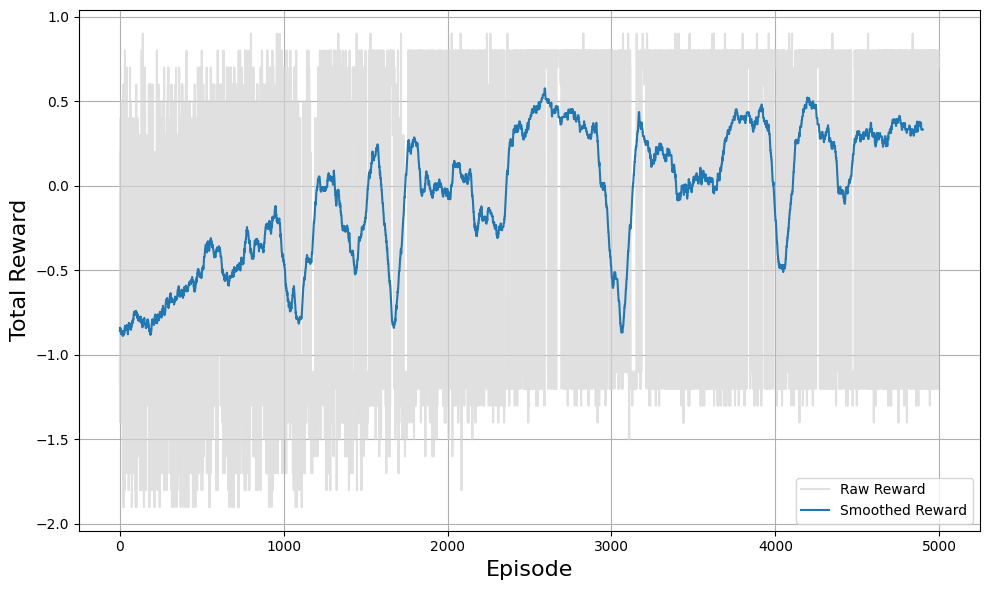

In [5]:
smoothed_rewards = moving_average(rewards, window_size=100)
plt.figure(figsize=(10,6))
plt.plot(rewards, color="lightgray", label="Raw Reward", alpha=0.7)
plt.plot(range(len(smoothed_rewards)), smoothed_rewards, label="Smoothed Reward")
plt.xlabel("Episode", fontsize=16)
plt.ylabel("Total Reward", fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

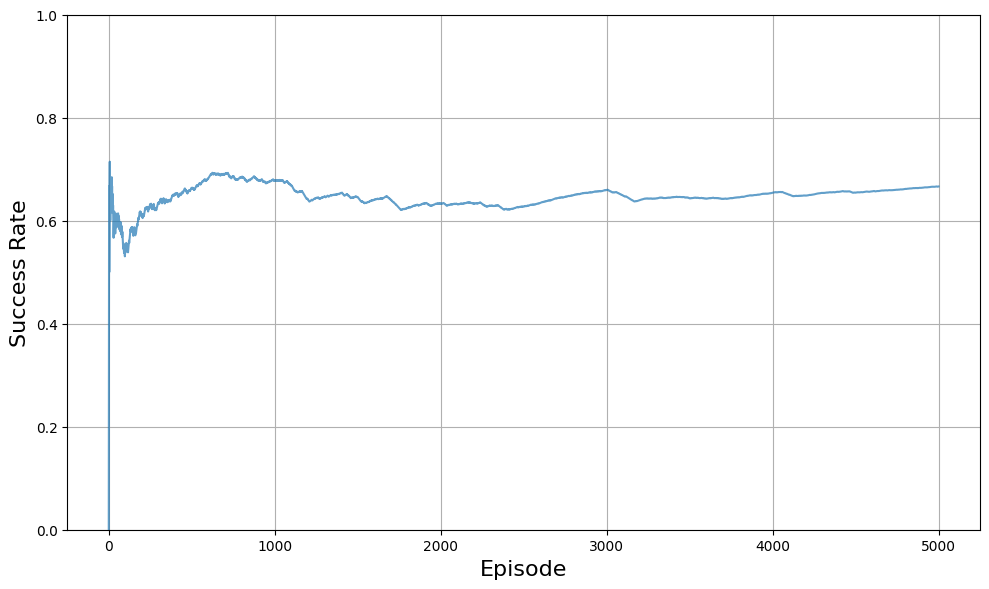

Diagnosis Success Rate: 66.62%


In [10]:
plt.figure(figsize=(10,6))
plt.plot(success_rates, alpha=0.7)
plt.xlabel("Episode", fontsize=16)
plt.ylabel("Success Rate", fontsize=16)
plt.ylim(0,1)
plt.grid(True)
plt.tight_layout()
plt.show()
print("Diagnosis Success Rate: " + str(round(success_rates[-1] * 100,2)) + "%")

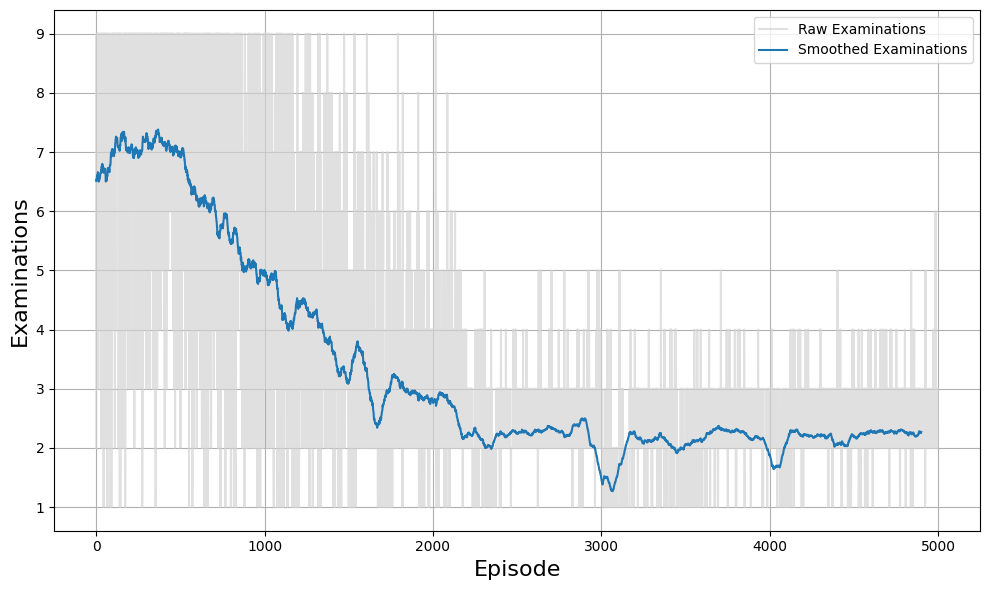

Average Examination per Diagnosis: 2.27


In [11]:
smoothed_examinations = moving_average(examinations_per_diagnosis, window_size=100)
plt.figure(figsize=(10,6))
plt.plot(examinations_per_diagnosis, color="lightgray", label="Raw Examinations", alpha=0.7)
plt.plot(range(len(smoothed_examinations)), smoothed_examinations, label="Smoothed Examinations")
plt.xlabel("Episode", fontsize=16)
plt.ylabel("Examinations", fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print("Average Examination per Diagnosis: " + str(round(smoothed_examinations[-1],2)))

In [8]:
def test_agent(env, agent, num_patients=10):
    number_of_diagnoses = len(df_neuro_diagnoses)
    print("Neurology Department, Number of possible Diagnosis: " + str(number_of_diagnoses))
    overall_correct_diagnoses = 0
    for num in range(number_of_diagnoses):
        correct_diagnoses = 0
        for patient_num in range(num_patients):
            state = env.set(num)
    
            exams_taken = []
            symptoms_history = []
    
            done = False
            step_count = 0
    
            while not done:
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                with torch.no_grad():
                    q_values = agent(state_tensor).squeeze()
                action = q_values.argmax().item()
                exam_taken = env.examinations[action]
    
                state, reward, done, info = env.step(action)
                observed_symptoms = env.get_observed_symptoms()
    
                exams_taken.append(exam_taken)
                symptoms_history.append(observed_symptoms)
    
                if info.get("forced", False):
                    if info["guess"] == info["diagnosis"]:
                        correct_diagnoses += 1
                        overall_correct_diagnoses += 1
                    break
    
                step_count += 1
    
        accuracy = correct_diagnoses / num_patients
        print(df_neuro_diagnoses.loc[num,'Diagnosis'].capitalize() + " - Accuracy over " + str(num_patients) + " patients: " + str(accuracy))
    print("Neurology Department - Overall Accuracy: " + str(round(overall_correct_diagnoses / (num_patients * number_of_diagnoses) * 100,2)) + "%")

In [9]:
test_agent(env, agent, num_patients=100)

Neurology Department, Number of possible Diagnosis: 29
Angle-closure glaucoma - Accuracy over 100 patients: 1.0
Blepharitis - Accuracy over 100 patients: 0.97
Botulism - Accuracy over 100 patients: 1.0
Cerebral contusion - Accuracy over 100 patients: 1.0
Cipd - Accuracy over 100 patients: 1.0
Cluster headache - Accuracy over 100 patients: 1.0
Concussion - Accuracy over 100 patients: 0.97
Conjunctivitis (allergic) - Accuracy over 100 patients: 0.91
Conjunctivitis (bacterial) - Accuracy over 100 patients: 0.75
Corneal abrasion - Accuracy over 100 patients: 0.67
Crvo - Accuracy over 100 patients: 0.54
Diffuse axonal injury - Accuracy over 100 patients: 0.68
Encephalitis - Accuracy over 100 patients: 1.0
Guillain-barre syndrome - Accuracy over 100 patients: 1.0
Hypertensive retinopathy - Accuracy over 100 patients: 0.69
Keratitis - bacterial - Accuracy over 100 patients: 0.0
Migraine - Accuracy over 100 patients: 1.0
Neuromyelitis optica - Accuracy over 100 patients: 0.91
Open-angle glauco

In [12]:
def test_diagnosis(env, agent, diagnosis, num_patients=5):
    int_diagnosis = int(df_neuro_diagnoses.index[df_neuro_diagnoses["Diagnosis"] == diagnosis].tolist()[0])
    correct_diagnoses = 0
    for patient_num in range(num_patients):
        state = env.set(int_diagnosis)

        print("\nPATIENT " + str(patient_num + 1))
        print("TRUE DIAGNOSIS: " + str(env.get_true_diagnosis()))
        print("TRUE SYMPTOMS (Generated for this patient): " + str(env.get_true_symptoms()) + "\n")

        exams_taken = []
        symptoms_history = []

        done = False
        step_count = 0

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                q_values = agent(state_tensor).squeeze()
            action = q_values.argmax().item()
            exam_taken = env.examinations[action]

            state, reward, done, info = env.step(action)
            observed_symptoms = env.get_observed_symptoms()

            exams_taken.append(exam_taken)
            symptoms_history.append(observed_symptoms)

            if info.get("forced", False):
                print("\nGuessed Diagnosis: " + str(info['guess'].capitalize()))
                if info["guess"] == info["diagnosis"]:
                    correct_diagnoses += 1
                break
                
            print("Step " + str(step_count + 1))
            print("Examination taken: " + str(exam_taken))
            print("Symptoms uncovered so far: " + str(observed_symptoms))

            step_count += 1
    
    accuracy = correct_diagnoses / num_patients
    print(str(diagnosis.capitalize()) + ": Accuracy over " + str(num_patients) + " patients: " + str(accuracy))

In [14]:
test_diagnosis(env, agent, "keratitis - bacterial", 5)


PATIENT 1
TRUE DIAGNOSIS: keratitis - bacterial
TRUE SYMPTOMS (Generated for this patient): ['eye pain', 'p. aeruginosa']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['eye pain']
Step 2
Examination taken: nasal cavity inspection
Symptoms uncovered so far: ['eye pain']

Guessed Diagnosis: Angle-closure glaucoma

PATIENT 2
TRUE DIAGNOSIS: keratitis - bacterial
TRUE SYMPTOMS (Generated for this patient): ['eye pain', 'itchy eyes', 'ocular hypertension', 'photophobia', 'watery eyes', 'p. aeruginosa']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['eye pain', 'itchy eyes', 'photophobia', 'watery eyes']
Step 2
Examination taken: biopsy testing
Symptoms uncovered so far: ['eye pain', 'itchy eyes', 'photophobia', 'watery eyes']

Guessed Diagnosis: Blepharitis

PATIENT 3
TRUE DIAGNOSIS: keratitis - bacterial
TRUE SYMPTOMS (Generated for this patient): ['eye pain', 'ocular hypertension', 'photophobia', 'watery eyes', 'p. aeruginosa']

Step 1
Examination tak

In [23]:
test_diagnosis(env, agent, "scleritis", 5)


PATIENT 1
TRUE DIAGNOSIS: scleritis
TRUE SYMPTOMS (Generated for this patient): ['eye pain', 'red eye', 'sclera changes']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['eye pain', 'red eye']
Step 2
Examination taken: biopsy testing
Symptoms uncovered so far: ['eye pain', 'red eye']

Guessed Diagnosis: Blepharitis

PATIENT 2
TRUE DIAGNOSIS: scleritis
TRUE SYMPTOMS (Generated for this patient): ['blurred vision', 'eye pain', 'watery eyes', 'sclera changes']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['blurred vision', 'eye pain', 'watery eyes']
Step 2
Examination taken: gonioscopy
Symptoms uncovered so far: ['blurred vision', 'eye pain', 'watery eyes', 'sclera changes']
Step 3
Examination taken: x ray upper limb
Symptoms uncovered so far: ['blurred vision', 'eye pain', 'watery eyes', 'sclera changes']

Guessed Diagnosis: Scleritis

PATIENT 3
TRUE DIAGNOSIS: scleritis
TRUE SYMPTOMS (Generated for this patient): ['blurred vision', 'sclera changes']


In [16]:
test_diagnosis(env, agent, "uveitis", 5)


PATIENT 1
TRUE DIAGNOSIS: uveitis
TRUE SYMPTOMS (Generated for this patient): ['eye pain', 'photophobia', 'retina scarring']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['eye pain', 'photophobia']
Step 2
Examination taken: biopsy testing
Symptoms uncovered so far: ['eye pain', 'photophobia']

Guessed Diagnosis: Angle-closure glaucoma

PATIENT 2
TRUE DIAGNOSIS: uveitis
TRUE SYMPTOMS (Generated for this patient): ['blurred vision', 'eye pain', 'photophobia', 'red eye', 'retina scarring']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['blurred vision', 'eye pain', 'photophobia', 'red eye']
Step 2
Examination taken: biopsy testing
Symptoms uncovered so far: ['blurred vision', 'eye pain', 'photophobia', 'red eye']

Guessed Diagnosis: Conjunctivitis (bacterial)

PATIENT 3
TRUE DIAGNOSIS: uveitis
TRUE SYMPTOMS (Generated for this patient): ['blurred vision', 'eye pain', 'retina scarring']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['